In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
from psis import psisloo

In [2]:
def plot_trend(x_axis, y_axis, tlitle=''):
    plt.plot(x_axis, y_axis)
    plt.rcParams['figure.figsize'] = (10,5)
    z = np.polyfit(x_axis, y_axis, 1)
    trend = np.poly1d(z)
    plt.plot(x_axis, trend(x_axis), 'r--')
    plt.xticks(np.arange(2004, 2018, 1))
    plt.xlabel('year')
    plt.ylabel('deaths')
    plt.title(tlitle)
    plt.show()

# Data preprocessing

In [3]:
def process_data():    
    data_years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
    for year in data_years:
        data = pd.read_csv(
            'data/project/csv/tieliikenneonnettomuudet_{0}_hlo.csv'.format(year), 
            sep=';', 
            encoding = "ISO-8859-1"
        )

        death = data.loc[data['Seuraussel'] == 'kuollut']
        gender = death['Sukupuoli'].values

        male = np.count_nonzero(gender == 'M')
        female = np.count_nonzero(gender == 'N')

        data = {'year': [year], 'male': [male], 'female': [female]}
        df = pd.DataFrame(data)

        df = df[['year', 'male', 'female']]
        df.to_csv('data/data.csv', mode='a', header=None, index=False)

# process_data()

## Number of death due to road traffic accidents in Finland

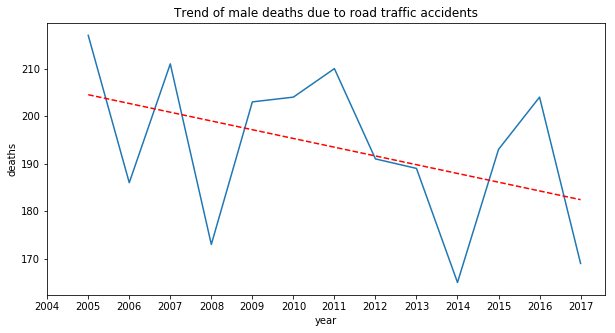

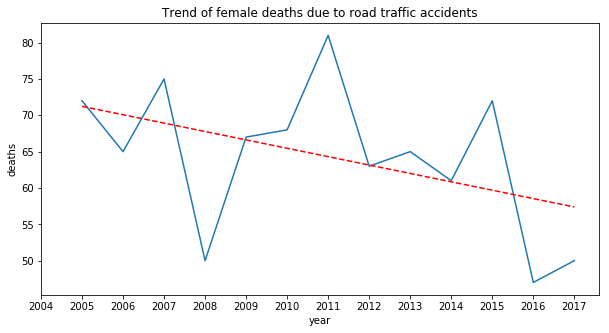

In [22]:
data = pd.read_csv('data/data.csv', sep = ',')
data['total']= data.iloc[:, 1:3].sum(axis=1)

years = data['year'].values
year_index = np.arange(1, len(years)+1)
male = data['male'].values
female = data['female'].values
total_deaths = data['total'].values
prediction_year = 14

mu = np.mean(total_deaths)
sigma = np.var(total_deaths)

# new params
N = len(total_deaths) * 2
num_groups = 2
x = np.arange(1, 3)
x = np.repeat(x, len(years))
group_indicator = np.arange(1, 3)
group_indicator = np.repeat(x, len(years))
combined = np.concatenate((male, female), axis=0)
plot_trend(years, male, 'Trend of male deaths due to road traffic accidents')
plot_trend(years, female, 'Trend of female deaths due to road traffic accidents')

# Models

# Pooled Model

In [5]:
# POOLED MODEL
pooled_factory_code = '''
data {
    int<lower=0> N;                // number of data points
    real xpred;                    // year to predict
    vector[N] number_of_deaths;
    vector[N] years;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + beta * years;
}

model {
    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    vector[N] log_lik;
    
    ypred = normal_rng(alpha + (beta * xpred), sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu, sigma);
}
'''

sm = pystan.StanModel(model_code = pooled_factory_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_95ea000215a3443c43c66dab4ed79507 NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmp9lgpywx4/stanfit4anon_model_95ea000215a3443c43c66dab4ed79507_6874942329671248069.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Pooled model to predict number of death due to road traffic accidents for male

In [6]:
accidents_data = {
    'N': len(male),
    'years': years,
    'number_of_deaths': male,
    'xpred': 2018,
}

pooled_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

In [7]:
def get_model_summary(model_fit):
    summary = model_fit.summary()
    summary = pd.DataFrame(
        summary['summary'], 
        columns=summary['summary_colnames'], 
        index=summary['summary_rownames']
    )

    log_lik = model_fit.extract(permuted=True)['log_lik']

    loo, loos, ks = psisloo(log_lik)
    print('PSIS-LOO value: {0}'.format(loo))

    S = np.shape(log_lik)[0]
    lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

    p_loocv = lppd - loo
    print('The effective number of parameters is: {0}'.format(p_loocv))

    print('K-hat values: {0}'.format(ks))

    return summary
    
get_model_summary(pooled_fit)

PSIS-LOO value: -973.153024881536
The effective number of parameters is: 294.93715124089124
K-hat values: [4.83839904 1.40483379 3.32476319 3.96194038 1.47452829 1.61400125
 3.00424419 0.91577028 1.07001484 6.23764525 0.89092746 1.61400125
 4.99427759]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,4083.123579,121.054251,2742.679274,-1225.389085,2300.545420,3986.447629,5708.589061,10155.346159,513.322095,1.017010
beta,-1.934173,0.060204,1.363875,-4.952710,-2.744435,-1.885823,-1.049709,0.703007,513.209010,1.017016
sigma,17.965438,0.140979,4.519787,11.642456,14.810638,17.062467,20.247994,29.219322,1027.843049,1.004858
mu[1],205.107346,0.365894,9.620550,185.913566,198.931470,204.933659,211.038705,225.342681,691.336799,1.010514
mu[2],203.173174,0.307395,8.503301,186.107271,197.798744,203.111227,208.431922,220.845469,765.212684,1.008991
mu[3],201.239001,0.249361,7.468439,186.411843,196.634908,201.219277,205.814558,216.447407,897.021669,1.007002
mu[4],199.304828,0.192276,6.555100,186.062348,195.278732,199.336507,203.379435,212.532384,1162.268183,1.004529
mu[5],197.370656,0.138218,5.820774,185.627287,193.835484,197.454410,200.892655,208.943451,1773.513936,1.001828
mu[6],195.436483,0.094735,5.339830,184.612595,192.162802,195.513052,198.672286,206.100154,3177.110554,0.999722
mu[7],193.502310,0.086100,5.183288,183.028910,190.332391,193.509907,196.702573,203.745463,3624.133208,0.999418


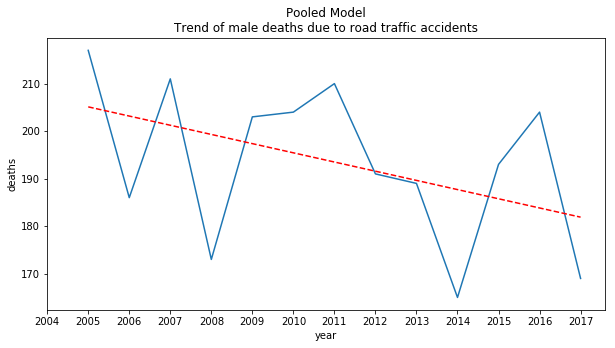

In [8]:
alpha = pooled_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = pooled_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, male)
plt.plot(years, [alpha + beta * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Pooled Model\nTrend of male deaths due to road traffic accidents')
plt.show()

In [9]:
def get_PSIS_LOO(model):
    """
    Get logposterior from the model, excluding the warmup perid
    Calculate the effective number of parameters p_eff
    Return PSIS-LOO estimates, p_eff
    """
    log_lik = model.extract(permuted=True)['log_lik']
    psis_loo, psis_loos_sep, k_values = psisloo(log_lik)
    
    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0)))
    p_eff = lppd - psis_loo
    
    return psis_loo, psis_loos_sep, k_values, p_eff

def quality_analysis(model):
    """
    Plots the resulting k_values
    """
    psis_loo, psis_loos_sep, k_values, p_eff = get_PSIS_LOO(model)
    
    print('PSIS-LOO estimate: {:.2f}\np_eff value: {:.2f}'.format(psis_loo, p_eff))
    
    pd.Series(k_values).plot(kind='bar', color='green', label='k-values', alpha=0.4)
    plt.title('K-values < 0.7: {0} out of {1}'.format(sum(k_values <= .7), len(k_values)))
    plt.hlines(0.7, -1, 30, label='0.7 threshhold', linestyles='dashed')
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.show()

PSIS-LOO estimate: -973.15
p_eff value: 294.94


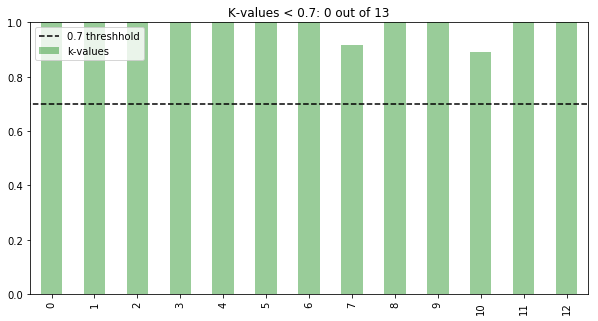

In [10]:
quality_analysis(pooled_fit)

### Predictions for 2018

In [ ]:
def plot_perdiction_histogram(fit, xlim, xticks, bins, title='', ypred='ypred'):
    y_pred = fit.extract()[ypred]
    plt.hist(y_pred, bins=bins, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(np.arange(xlim[0], xlim[1], xticks))
    plt.title(title)
    plt.show()

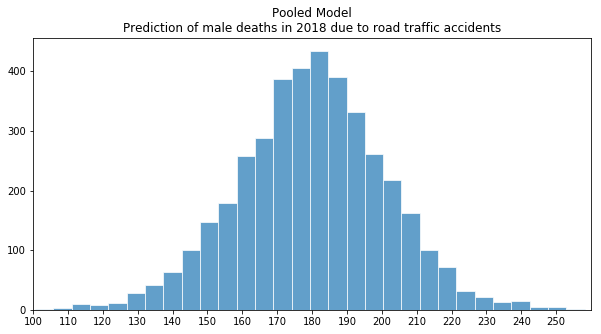

In [21]:
plot_perdiction_histogram(
    pooled_fit, 
    ypred='ypred',
    xlim=[100, 260], 
    xticks=10, 
    bins=40,
    title='Pooled Model\nPrediction of male deaths in 2018 due to road traffic accidents'
)

## Separate Model

In [11]:
# SEPARATE MODEL
accidents_code = '''
data {
    int<lower=0> N;                 // number of data points
    int<lower=0> K;                 // number of groups
    int<lower=1,upper=K> group[N];  // group indicator
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years;
}

parameters {
    vector[K] alpha;
    vector[K] beta;
    vector<lower=0>[K] sigma;
}

transformed parameters{
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[group[i]] + beta[group[i]] * years[i];
}

model {
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma[group[i]]);
}

generated quantities {
    real male_pred;
    real female_pred;
    vector[N] log_lik;

    male_pred = normal_rng(alpha[1] + beta[1] * xpred, sigma[1]);
    female_pred = normal_rng(alpha[2] + beta[2] * xpred, sigma[2]);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma[group[i]]);
}
'''

accidents_data = {
    'N': N,
    'K': num_groups,
    'group': x,
    'number_of_deaths': combined,
    'years': list(years)*2,
    'xpred': 2018,
}

sm = pystan.StanModel(model_code = accidents_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e871fea1545dd5f54a8ec22401d9e147 NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmpgv3n5p3h/stanfit4anon_model_e871fea1545dd5f54a8ec22401d9e147_7616293309146626233.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [12]:
separate_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

### Separate model evaluation

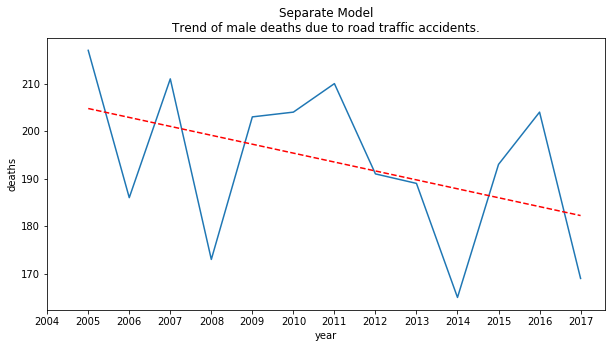

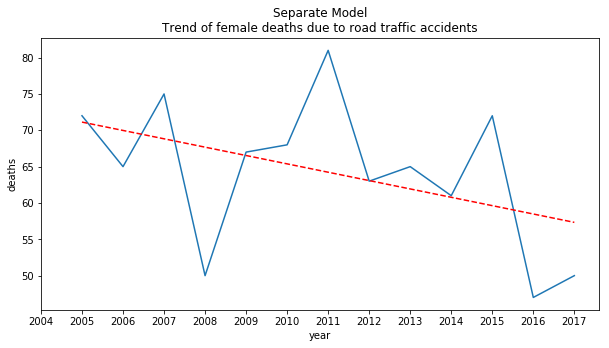

In [13]:
alpha = separate_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = separate_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, male)
plt.plot(years, [alpha[0] + beta[0] * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of male deaths due to road traffic accidents.')
plt.show()

plt.plot(years, female)
plt.plot(years, [alpha[1] + beta[1] * i for i in range(2005, 2018)], 'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of female deaths due to road traffic accidents')
plt.show()

PSIS-LOO estimate: -106.53
p_eff value: 4.81


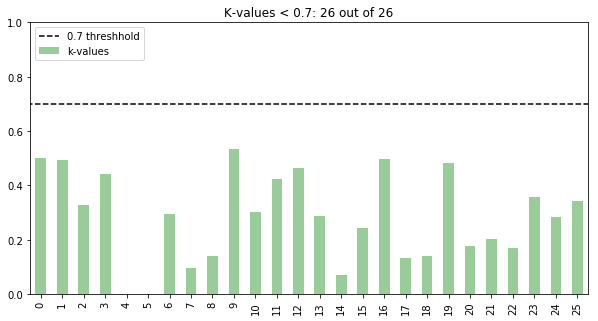

In [14]:
quality_analysis(separate_fit)

### Predictions for 2018

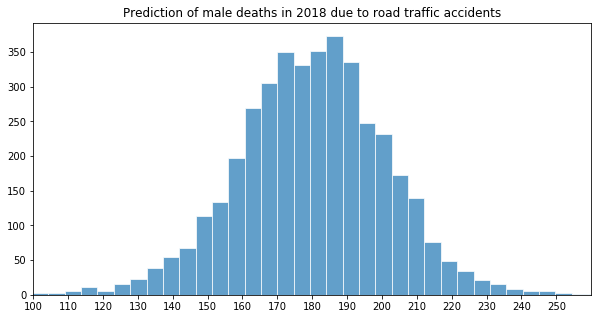

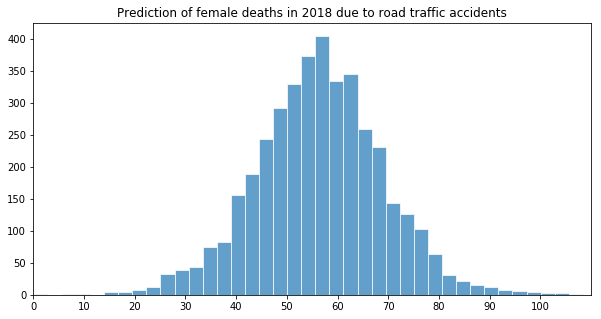

In [16]:
plot_perdiction_histogram(
    separate_fit, 
    ypred='male_pred',
    xlim=[100, 260], 
    xticks=10, 
    bins=40,
    title='Prediction of male deaths in 2018 due to road traffic accidents'
)

plot_perdiction_histogram(
    separate_fit, 
    ypred='female_pred',
    xlim=[0, 110], 
    xticks=10, 
    bins=40,
    title='Prediction of female deaths in 2018 due to road traffic accidents'
)

In [17]:
print('Prediction of male deaths in 2018:  \t {0}'.format( 
    round(np.mean(separate_fit.extract()['male_pred']))) 
 )
print('Prediction of female deaths in 2018:\t {0}'.format( 
    round(np.mean(separate_fit.extract()['female_pred']))) 
 )

Prediction of male deaths in 2018:  	 180.0
Prediction of female deaths in 2018:	 56.0


In [18]:
summary = separate_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = separate_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -106.52594941892747
The effective number of parameters is: 4.806108321021327
K-hat values: [ 0.50008591  0.49174946  0.32778529  0.44060223 -0.02533292 -0.02068486
  0.29551955  0.09755037  0.1398493   0.53349269  0.3003471   0.42178039
  0.46324631  0.28776432  0.06975481  0.24410355  0.49691538  0.13301205
  0.13867586  0.48057163  0.17567611  0.20334048  0.16832819  0.35818195
  0.28423647  0.34158269]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha[1],3968.231793,80.132741,2849.010729,-1551.389185,2126.155907,3952.832528,5794.664886,9415.933676,1264.061402,1.006228
alpha[2],2376.427701,43.799921,1629.130668,-778.981983,1340.090222,2341.541368,3402.854933,5715.347842,1383.455494,1.001195
beta[1],-1.877044,0.039846,1.416685,-4.587632,-2.785605,-1.869909,-0.961421,0.867762,1264.072538,1.006232
beta[2],-1.149775,0.021780,0.810106,-2.810318,-1.661037,-1.131084,-0.634175,0.419293,1383.437066,1.001196
sigma[1],17.999622,0.117279,4.549103,11.677100,14.809368,17.239185,20.135228,29.413056,1504.553618,1.002344
sigma[2],10.753426,0.061071,2.622538,6.997335,9.000302,10.342375,11.963180,17.086141,1844.043711,0.999979
mu[1],204.758028,0.256160,9.944687,184.695955,198.569537,204.838655,210.938478,223.814318,1507.160698,1.003540
mu[2],202.880984,0.219145,8.756205,185.498923,197.469717,202.915875,208.319268,220.082022,1596.498719,1.002945
mu[3],201.003940,0.185235,7.645877,185.614780,196.350859,201.025234,205.687237,216.080111,1703.760447,1.002163
mu[4],199.126895,0.153443,6.652951,185.664993,195.063078,199.170133,203.210284,212.325891,1879.894116,1.001179


<h2>DON'T TOUCH</h2>

In [ ]:
# POOLED MODEL
accidents_code = '''
data {
    int <lower=0> N;             //number of data points
    vector[N] year;              //observation year
    vector[N] number_of_deaths;  //total number of deaths
    real prediction_year;        //prediction year
    
    real mean_data;
    real variance_data;
}

parameters {
    real alpha;
    real beta;
    real <lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + (beta * year);
}

model {
    beta ~ normal(mean_data, variance_data);
    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    real ypred;
    ypred = normal_rng(alpha + (beta * prediction_year), sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu, sigma);
}
'''
model = pystan.StanModel(model_code=accidents_code)

In [ ]:
def stan_sampling_fit(deaths, years, year_to_predict):
    accidents_data = {
        'N': len(deaths),
        'year': years,
        'number_of_deaths': deaths,
        'prediction_year': year_to_predict,
        'mean_data': mu,
        'variance_data': sigma
    }
    return model.sampling(data = accidents_data, control = {'adapt_delta': 0.95, 'max_treedepth': 15})

In [ ]:
accidents_fit = stan_sampling_fit(total_deaths, years, prediction_year)
summary = accidents_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

summary

In [ ]:
log_lik = accidents_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('KS value: {0}'.format(ks))

#### Predictions for total number of deaths in 2018

In [ ]:
def plot_perdiction_histogram(fit, xlim, xticks):
    y_pred = fit.extract()['ypred']
    plt.hist(y_pred, bins=40, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(xticks)
    plt.show()

In [ ]:
plot_perdiction_histogram(
    accidents_fit, 
    xlim=[120, 350], 
    xticks=np.arange(120, 360, 20)
)

## Male death due to road traffic accidents in Finland

In [ ]:
plot_trend(years, male)

In [ ]:
accidents_fit_male = stan_sampling_fit(male, years, prediction_year)
summary_male = accidents_fit_male.summary()
summary_male = pd.DataFrame(
    summary_male['summary'], 
    columns=summary_male['summary_colnames'], 
    index=summary_male['summary_rownames']
)

summary_male

#### Predictions for number of male deaths in 2018

In [ ]:
plot_perdiction_histogram(
    accidents_fit_male, 
    xlim=[110, 260], 
    xticks=np.arange(110, 260, 10)
)

## Female death due to road traffic accidents in Finland

In [ ]:
plot_trend(years, female)

In [ ]:
accidents_fit_female = stan_sampling_fit(female, years, prediction_year)
summary_female = accidents_fit_female.summary()
summary_female = pd.DataFrame(
    summary_female['summary'], 
    columns=summary_female['summary_colnames'], 
    index=summary_female['summary_rownames']
)

summary_female

### Predictions for number of female deaths in 2018

In [ ]:
plot_perdiction_histogram(
    accidents_fit_female, 
    xlim=[0, 110], 
    xticks=np.arange(0, 110, 10)
)